# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import numpy as np
import os
import pandas as pd
import plotly.express as px
import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patheffects as pe
from itertools import combinations_with_replacement
from dataclasses import dataclass
from collections.abc import Callable
from tqdm import tqdm
from scipy.stats import chi2
from sklearn.model_selection import KFold
import pickle

from data import *
from plotting import *
from regression import *
from utils import *

In [5]:
results_dir = 'results/2August/'
os.makedirs(results_dir, exist_ok=True)

# Data preparation

In [6]:
# Load data
pcd_df = load_pcd_df()

In [7]:
pcd_df

,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Training compute cost (2023 USD),Training dataset size,Sparsity,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share)
0,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",Gemini Team,"SOTA improvement,Training cost",""" Evaluation on a broad range of benchmarks sh...",Hosted access (no API),https://storage.googleapis.com/deepmind-media/...,633.0,Gemini: A Family of Highly Capable Multimodal ...,...,$29827341.92,Gemini 1.0 Ultra,NaN,NaN,NaN,192.0,10560000,NaN,5.000000e+25,100%
1,Llama 3.1-405B,Language,Language modelling/generation,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...","SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",Open access (restricted use),https://ai.meta.com/research/publications/the-...,NaN,The Llama 3 Herd of Models,...,NaN,NaN,NaN,NaN,NaN,700.0,0,NaN,3.800000e+25,100%
2,GPT-4,"Multimodal,Language,Vision,Image generation",Language modelling,"OpenAI, Josh Achiam, Steven Adler, Sandhini Ag...","Highly cited,SOTA improvement,Training cost","See the paper, p.1: ""On a suite of traditional...",API access,https://arxiv.org/abs/2303.08774,5290.0,GPT-4 Technical Report,...,$40586592.58,GPT-4,GPT-4,(Speculative) SemiAnalysis conjectures that GP...,NaN,400.0,10000000,NaN,2.100000e+25,100%
3,Mistral Large,Language,Chat,NaN,Training cost,~$20M training cost: https://www.wsj.com/tech/...,API access,https://mistral.ai/news/mistral-large/,NaN,"Mistral Large, our new flagship model",...,NaN,Mistral Large,NaN,NaN,NaN,350.0,0,NaN,2.000000e+25,100%
4,Nemotron-4 340B,Language,"Language modelling/generation,Chat","Bo Adler, Niket Agarwal, Ashwath Aithal, Dong ...",Training cost,"~2e25 FLOP, so high training cost, likely >5M",Open source,https://blogs.nvidia.com/blog/nemotron-4-synth...,NaN,NVIDIA Releases Open Synthetic Data Generation...,...,NaN,Nemotron-4 340B,NaN,NaN,NaN,700.0,0,NaN,1.800000e+25,100%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601,Multilingual DNN,Speech,Speech recognition,"G. Heigold, Vincent Vanhoucke, A. Senior, Patr...","SOTA improvement,Training cost",NaN,NaN,https://www.semanticscholar.org/paper/Multilin...,NaN,Multilingual acoustic models using distributed...,...,NaN,Multilingual DNN,NaN,NaN,NaN,NaN,0,NaN,0.000000e+00,NaN
1602,DeViSE,Vision,Semantic embedding,"Andrea Frome, G. Corrado, Jonathon Shlens, Sam...","Highly cited,SOTA improvement",NaN,NaN,https://www.semanticscholar.org/paper/DeViSE%3...,NaN,DeViSE: A Deep Visual-Semantic Embedding Model,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000e+00,NaN
1603,OpenVLA,Robotics,NaN,"Moo Jin Kim, Karl Pertsch, Siddharth Karamchet...",NaN,"claimed SOTA\n\n""OpenVLA outperforms the 55B-p...",Open access (restricted use),https://openvla.github.io/ ; https://arxiv.org...,NaN,OpenVLA: An Open-Source Vision-Language-Action...,...,NaN,NaN,NaN,NaN,NaN,400.0,25600,8.400000e+22,-9.100000e+22,-Infinity
1604,Mistral NeMo,Language,"Language modelling/generation,Code generation","Albert Jiang, Alexandre Sablayrolles, Alexis T...",NaN,NaN,Open source,https://mistral.ai/news/mistral-nemo/,NaN,Mistral NeMo,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000e+00,NaN


In [8]:
pcd_df.loc[pcd_df['System'] == 'Megatron-BERT']['Model accessibility']

216    Unreleased
Name: Model accessibility, dtype: object

In [9]:
access_df = pcd_df.dropna(subset=['Publication date', 'Training compute (FLOP)'])
len(access_df)

717

In [10]:
access_df['Model accessibility'].unique()

array(['Hosted access (no API)', 'Open access (restricted use)',
       'API access', 'Open source', 'Unreleased', nan,
       'Open access (non-commercial)'], dtype=object)

In [11]:
for cat in access_df['Model accessibility'].unique():
    if pd.isna(cat):
        print(cat, len(access_df.loc[access_df['Model accessibility'].isna()]))
    else:
        print(cat, len(access_df.loc[access_df['Model accessibility'] == cat]))

Hosted access (no API) 10
Open access (restricted use) 54
API access 27
Open source 203
Unreleased 204
nan 169
Open access (non-commercial) 50


In [12]:
open_access_categories = ['Open source', 'Open access (restricted use)', 'Open access (non-commercial)']
closed_access_categories = ['API access', 'Hosted access (no API)', 'Unreleased']

In [13]:
def get_access_label(access_category):
    if pd.isna(access_category):
        return 'Unknown'
    elif access_category in open_access_categories:
        return 'Open'
    elif access_category in closed_access_categories:
        return 'Closed'
    else:
        return 'Unknown'

# Add column with binary access label
access_df.loc[:, 'Model open/closed'] = access_df['Model accessibility'].apply(
    lambda x: get_access_label(x)
)

/var/folders/s2/stl5t_bn7xg9vdfxxr71rzrc0000gn/T/ipykernel_40465/3052041378.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df.loc[:, 'Model open/closed'] = access_df['Model accessibility'].apply(


In [14]:
access_df

,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Training dataset size,Sparsity,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed
0,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",Gemini Team,"SOTA improvement,Training cost",""" Evaluation on a broad range of benchmarks sh...",Hosted access (no API),https://storage.googleapis.com/deepmind-media/...,633.0,Gemini: A Family of Highly Capable Multimodal ...,...,Gemini 1.0 Ultra,NaN,NaN,NaN,192.0,10560000,NaN,5.000000e+25,100%,Closed
1,Llama 3.1-405B,Language,Language modelling/generation,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...","SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",Open access (restricted use),https://ai.meta.com/research/publications/the-...,NaN,The Llama 3 Herd of Models,...,NaN,NaN,NaN,NaN,700.0,0,NaN,3.800000e+25,100%,Open
2,GPT-4,"Multimodal,Language,Vision,Image generation",Language modelling,"OpenAI, Josh Achiam, Steven Adler, Sandhini Ag...","Highly cited,SOTA improvement,Training cost","See the paper, p.1: ""On a suite of traditional...",API access,https://arxiv.org/abs/2303.08774,5290.0,GPT-4 Technical Report,...,GPT-4,GPT-4,(Speculative) SemiAnalysis conjectures that GP...,NaN,400.0,10000000,NaN,2.100000e+25,100%,Closed
3,Mistral Large,Language,Chat,NaN,Training cost,~$20M training cost: https://www.wsj.com/tech/...,API access,https://mistral.ai/news/mistral-large/,NaN,"Mistral Large, our new flagship model",...,Mistral Large,NaN,NaN,NaN,350.0,0,NaN,2.000000e+25,100%,Closed
4,Nemotron-4 340B,Language,"Language modelling/generation,Chat","Bo Adler, Niket Agarwal, Ashwath Aithal, Dong ...",Training cost,"~2e25 FLOP, so high training cost, likely >5M",Open source,https://blogs.nvidia.com/blog/nemotron-4-synth...,NaN,NVIDIA Releases Open Synthetic Data Generation...,...,Nemotron-4 340B,NaN,NaN,NaN,700.0,0,NaN,1.800000e+25,100%,Open
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,Linear Decision Functions,Mathematics,Binary classification,W. Highleyman,"Historical significance,Highly cited",NaN,NaN,https://ieeexplore.ieee.org/document/4066882?d...,NaN,"Linear Decision Functions, with Application to...",...,Linear Decision Functions,NaN,NaN,NaN,NaN,0,NaN,1.559250e+06,100%,Unknown
713,Heuristic Reinforcement Learning,Robotics,NaN,"M. Waltz, K. Fu","Historical significance,Highly cited",NaN,NaN,https://ieeexplore.ieee.org/document/1098193,NaN,A heuristic approach to reinforcement learning...,...,Heuristic Reinforcement Learning,NaN,NaN,NaN,NaN,0,NaN,1.080000e+06,100%,Unknown
714,Perceptron Mark I,Other,Binary classification,F Rosenblatt,"Historical significance,Highly cited",First modern neural network,NaN,https://blogs.umass.edu/brain-wars/files/2016/...,1610.0,The Perceptron—a perceiving and recognizing au...,...,Perceptron Mark I,NaN,NaN,NaN,NaN,0,NaN,6.948949e+05,100%,Unknown
715,ADALINE,Vision,Pattern recognition,Widrow and Hoff,Highly cited,NaN,NaN,https://isl.stanford.edu/~widrow/papers/c1960a...,6329.0,Adaptive switching circuits,...,ADALINE,NaN,NaN,NaN,NaN,0,NaN,9.900000e+03,100%,Unknown


In [15]:
print('Closed', len(access_df[access_df['Model open/closed'] == 'Closed']))
print('Open', len(access_df[access_df['Model open/closed'] == 'Open']))
print('Unknown', len(access_df[access_df['Model open/closed'] == 'Unknown']))

Closed 241
Open 307
Unknown 169


In [16]:
df = access_df

In [17]:
# 'external': Filter to the top n models overall
# 'internal': Filter to the top n models within 'Open' and 'Closed' categories
# 'disabled': No filtering
frontier_selection = 'external'  # ['disabled', 'internal', 'external']
top_n = 10  # Filter to the top n models by training compute at time of release
model_selection = 'All models'  # ['All models', 'Language models', 'Google DeepMind models', 'OpenAI models', 'Meta AI models']
filter_alphago_outliers = True
filter_finetuned_models = True
cutoff_date = '2018-01-01'

In [18]:
def find_top_models_up_to_release(df, top_n):
    """Find the models which were in the top n by compute when they were released."""
    # This set will keep track of models that were ever in the top 10 at their release
    ever_in_top_n = set()

    # Iterate over each date in the DataFrame
    for current_date in df['date'].unique():
        # Get all entries up to the current date
        historical_data = df[df['date'] <= current_date]
        # Find top 10 models by flop count in this subset
        top_n_models = historical_data.nlargest(top_n, 'flop')['System']
        # Update the set of models that were ever in top n
        ever_in_top_n.update(top_n_models)

    # Return DataFrame filtered to only include models that were ever in the top 10
    return df[df['System'].isin(ever_in_top_n)]


def filter_top_models_within_category(df, top_n, cutoff_date, category):
    """Find the models which were in the top n by compute when they were released."""
    # Filter top-n models within the category, but seeded with overall top-n models
    top_models_df = find_top_models_up_to_release(df, top_n)
    top_n_models_at_cutoff_date_df = top_models_df[top_models_df['date'] <= cutoff_date].nlargest(top_n, 'flop')
    category_df = df[df['category'] == category]

    # This set will keep track of models that were ever in the top 10 at their release
    ever_in_top_n = set()

    # Iterate over each date in the DataFrame
    for current_date in category_df['date'].unique():
        # if current_date < pd.to_datetime(cutoff_date):
        #     continue
        # Get all entries up to the current date
        historical_data = pd.concat([category_df[category_df['date'] <= current_date], top_n_models_at_cutoff_date_df])
        # Find top 10 models by flop count in this subset
        top_n_models_df = historical_data.nlargest(top_n, 'flop')
        # Update the set of models that were ever in top n
        # Filter out the models that aren't in the category
        ever_in_top_n.update(top_n_models_df[top_n_models_df['category'] == category]['System'])

    # Return DataFrame filtered to only include models that were ever in the top 10
    return df[df['System'].isin(ever_in_top_n)]


def filter_top_models_in_both_categories(df, top_n, cutoff_date):
    # Get top models for Open and Closed categories
    top_open_models = filter_top_models_within_category(df, top_n, cutoff_date, category='Open')
    top_closed_models = filter_top_models_within_category(df, top_n, cutoff_date, category='Closed')
    # Combine the results
    df_filtered = pd.concat([top_open_models, top_closed_models])
    # Sort the combined DataFrame by date
    df_filtered = df_filtered.sort_values('date')
    return df_filtered

In [19]:
df_filtered = (df[['System', 'Training compute (FLOP)', 'Publication date', 'Organization', 'Notability criteria', 'Domain', 'Base model', 'Model open/closed']]
    .rename(columns={'Training compute (FLOP)': 'flop', 'Publication date': 'date', 'Model open/closed': 'category'})
    .assign(date=lambda x: pd.to_datetime(x['date']), log_flop=lambda x: np.log10(x['flop']))
    .sort_values('date'))
list(df_filtered[df_filtered['Base model'].notna()]['System'])

['Layer Normalization: Handwriting sequence generation',
 'ULM-FiT',
 'ADP-FAIRSEQ + NGRAMRES',
 'Cross-lingual alignment',
 'UnifiedQA',
 '$\\infty$-former (SM)',
 'FLAN 137B',
 'AlphaFold-Multimer',
 'Masked Autoencoders',
 'Contriever',
 'BERT-RBP',
 'Minerva (540B)',
 'BlenderBot 3',
 'PaLM-SayCan',
 'NMST+GPT-2',
 'Decaying Fast Weights Transformer (WT-103)',
 'GPT-2 + Progressive LRD',
 'U-PaLM (540B)',
 'Flan-T5 11B',
 'Flan-PaLM 540B',
 'Taiyi-Stable Diffusion',
 'OPT-IML (175B)',
 'SparseOPT-175B',
 'DiT-XL/2',
 'VideoMAE V2',
 'Segment Anything Model',
 'gLM',
 'MOSS-Moon-003',
 'WizardLM-7B',
 'InstructBLIP',
 'Guanaco-65B',
 'WizardCoder-15.5B',
 'Code Llama-34B',
 'Code Llama-7B',
 'TigerBot-70B',
 'MiniGPT4 (Vicuna finetune)',
 'LLaMA-7B (protein-oriented instructions finetuned)',
 'FinGPT-13B',
 'LLaVA 1.5',
 'CogVLM',
 'Volcano 13B',
 'SPHINX (Llama 2 13B)',
 'Orca 2-13B',
 'Llama Guard',
 'FunSearch',
 'Elyza',
 'Code Llama-70B',
 'Swallow']

In [20]:
df_filtered = (df[['System', 'Training compute (FLOP)', 'Publication date', 'Organization', 'Notability criteria', 'Domain', 'Base model', 'Model open/closed']]
    .rename(columns={'Training compute (FLOP)': 'flop', 'Publication date': 'date', 'Model open/closed': 'category'})
    .assign(date=lambda x: pd.to_datetime(x['date']), log_flop=lambda x: np.log10(x['flop']))
    .sort_values('date'))

# Drop Alpha Go Master / Zero
if filter_alphago_outliers:
    mask = (df_filtered["System"] == 'AlphaGo Master') | (df_filtered["System"] == 'AlphaGo Zero')
    df_filtered = df_filtered[~mask]

# Drop finetuned models
if filter_finetuned_models:
    mask = df_filtered['Base model'].isna()
    df_filtered = df_filtered[mask]

top_models_df = find_top_models_up_to_release(df_filtered, top_n)  # For reference

if frontier_selection == 'external':
    # Filter top models before other filters
    df_filtered = filter_top_models_in_both_categories(df_filtered, top_n, cutoff_date)

if model_selection == 'Language models':
    re = 'Language|Multimodal'
    mask = df_filtered['Domain'].str.contains(re, na=False)
    df_filtered = df_filtered[mask]

if frontier_selection == 'internal':
    # Filter top models after other filters
    df_filtered = filter_top_models_in_both_categories(df_filtered, top_n, cutoff_date)

# Filter for models after the cutoff date
df_filtered = df_filtered[df_filtered['date'] > cutoff_date]

print(f"{len(df_filtered)}{' top' if frontier_selection != 'disabled' else ''} {model_selection} models found")
print(f"They span {df_filtered['date'].min().strftime('%B %Y')} to {df_filtered['date'].max().strftime('%B %Y')}")

112 top All models models found
They span February 2018 to July 2024


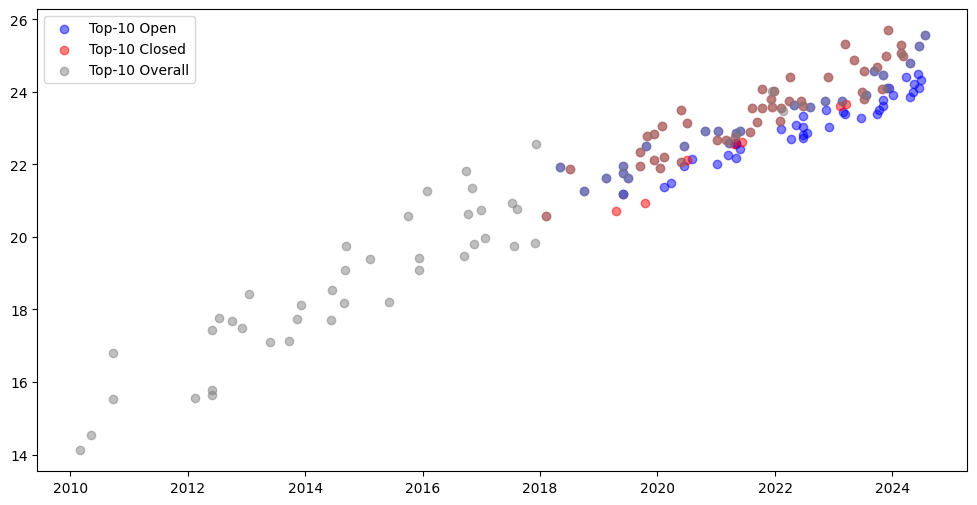

In [21]:
plt.figure(figsize=(12, 6))
# # Top open
plt.scatter(df_filtered['date'][df_filtered['category'] == 'Open'], df_filtered['log_flop'][df_filtered['category'] == 'Open'], 
            alpha=0.5, color='blue', label=f'Top-{top_n} Open')
# Top closed
plt.scatter(df_filtered['date'][df_filtered['category'] == 'Closed'], df_filtered['log_flop'][df_filtered['category'] == 'Closed'], 
            alpha=0.5, color='red', label=f'Top-{top_n} Closed')
# Overall top models after 2010-01-01
plt.scatter(top_models_df['date'][top_models_df['date'] > pd.to_datetime('2010-01-01')], top_models_df['log_flop'][top_models_df['date'] > pd.to_datetime('2010-01-01')], 
            alpha=0.5, color='grey', label=f'Top-{top_n} Overall')
plt.legend()
plt.show()

# Regression analysis

## Model selection

In [22]:
# Analysis of best fit to the data

@dataclass
class FitResult:
    p: int = None
    bic: float = None
    rss: float = None
    mse: float = None
    predict: Callable = None


@dataclass
class KinkedFitResult(FitResult):
    break_points: tuple[float] = None
    break_points_dt: float = None
    oom_year_slopes: tuple[float] = None
    intercepts: tuple[float] = None

    # Model properties for each breakpoint combination
    # (for debugging)
    bics: tuple[float] = None
    rsss: tuple[float] = None
    mses: tuple[float] = None
    break_points_list: tuple[tuple[float]] = None
    break_points_dt_list: tuple[tuple[float]] = None


def get_predictors(
    x,
    intercept_change_points,
    slope_change_points,
    pred_category=None,category=None,
    same_intercepts=None,
    same_slopes=None
):
    if pred_category == 'Open':
        is_open = np.ones(len(x))
    elif pred_category == 'Closed':
        is_open = np.zeros(len(x))
    else:
        assert category is not None
        is_open = (category == 'Open').astype(int).values

    # Ensure the lengths match
    assert len(same_intercepts) == len(intercept_change_points), "Length of same_intercepts must match the number of intercept change points"
    assert len(same_slopes) == len(slope_change_points), "Length of same_slopes must match the number of slope change points"

    # Calculate the number of columns needed
    n_intercept_cols = sum(1 if same else 2 for same in same_intercepts)
    n_slope_cols = sum(1 if same else 2 for same in same_slopes)
    n_cols = n_intercept_cols + n_slope_cols

    predictors = np.zeros((len(x), n_cols))

    # Intercept predictors
    col_idx = 0
    for i, (intercept_point, same) in enumerate(zip(intercept_change_points, same_intercepts)):
        if same:
            predictors[:, col_idx] = (x >= intercept_point).astype(int)
            col_idx += 1
        else:
            predictors[:, col_idx] = (x >= intercept_point).astype(int) * is_open
            predictors[:, col_idx + 1] = (x >= intercept_point).astype(int) * (1 - is_open)
            col_idx += 2

    # Slope predictors
    for i, (break_point, same) in enumerate(zip(slope_change_points, same_slopes)):
        if same:
            predictors[:, col_idx] = np.maximum(x - break_point, 0)
            col_idx += 1
        else:
            predictors[:, col_idx] = np.maximum(x - break_point, 0) * is_open
            predictors[:, col_idx + 1] = np.maximum(x - break_point, 0) * (1 - is_open)
            col_idx += 2

    return predictors


def fit_n_phase_exponential(
    df,
    kink_count,
    allow_discontinuities=False,
    same_intercepts=None,
    same_slopes=None,
    min_n_segment=10
):
    # Generate monthly breakpoints between 2010 and 2024
    one_month = pd.DateOffset(months=1)
    break_point_grid = pd.date_range(start=df['date'].min() - one_month, end=df['date'].max() - 4*one_month, freq='MS')
    break_point_grid = [x.toordinal() for x in break_point_grid]

    x = pd.to_datetime(df['date']).apply(lambda date: date.toordinal()).values
    y = df['log_flop'].values

    break_points_list = []
    bics = []
    rsss = []
    mses = []
    models = []

    for break_points in combinations_with_replacement(break_point_grid, kink_count):
        intercept_change_points = (0,)
        if allow_discontinuities:
            intercept_change_points += break_points
        slope_change_points = (0,) + break_points

        # If same_intercepts or same_slopes are not provided, default to all False
        if same_intercepts is None:
            same_intercepts = [False] * len(intercept_change_points)
        if same_slopes is None:
            same_slopes = [False] * len(slope_change_points)

        predictors = get_predictors(
            x,
            intercept_change_points,
            slope_change_points,
            category=df['category'],
            same_slopes=same_slopes,
            same_intercepts=same_intercepts
        )

        # Fit the model
        model = sm.OLS(y, predictors).fit()

        # Calculate BIC manually based on log-likelihood
        n = len(x) # Number of observations
        p = len(model.params) + 2*kink_count + 1 # Number of parameters

        # Calculate log-likelihood under the assumption of normally distributed errors
        # We have to iterate over all points to get their individual log-likelihoods
        log_likelihood = 0
        rss = 0
        invalid_model = False # Discard models with segments with less than 2 points
        for i, break_point in enumerate(slope_change_points):
            left_x = break_point
            right_x = slope_change_points[i + 1] if i + 1 < len(slope_change_points) else np.inf

            segment_predictors = predictors[(left_x <= x) & (x < right_x), :]
            segment_y = y[(left_x <= x) & (x < right_x)]
            segment_n = len(segment_y)

            assert min_n_segment > 2

            if segment_n < min_n_segment:
                invalid_model = True
                break

            y_pred = model.predict(segment_predictors)

            segment_rss = np.sum((y_pred - segment_y)**2)
            assert segment_rss > 0
            segment_mse = segment_rss / segment_n

            segment_log_likelihood = -segment_n/2 * (np.log(2*np.pi) + np.log(segment_rss/segment_n) + 1)
            log_likelihood += segment_log_likelihood
            rss += segment_rss

        if invalid_model:
            continue

        # Compute BIC using the manual method based on the log-likelihood
        bic = p * np.log(n) - 2 * log_likelihood
        # bic = n*np.log(rss/n) + p*np.log(n)

        bics.append(bic)
        rsss.append(rss)
        mses.append(rss/len(df))
        models.append(model)
        break_points_list.append(break_points)

    # Prepare the result object
    best_bic = min(bics)
    best_idx = bics.index(best_bic)
    best_rss = rsss[best_idx]
    best_mse = mses[best_idx]
    best_model = models[best_idx]
    best_break_points = break_points_list[best_idx]

    p = len(best_model.params) + 2*kink_count + 1 # Number of parameters

    # Store the model parameters
    intercept_change_points = (0,)
    if allow_discontinuities:
        intercept_change_points += best_break_points
    slope_change_points = (0,) + best_break_points

    n_intercepts = sum(1 if same else 2 for same in same_intercepts)
    intercepts = best_model.params[:n_intercepts]
    oom_intercepts = np.zeros((2, len(intercept_change_points)))
    for i in range(len(intercept_change_points)):
        if same_intercepts[i]:
            oom_intercepts[0, i] = oom_intercepts[1, i] = intercepts[i]
        else:
            oom_intercepts[0, i] = intercepts[2*i - sum(same_intercepts[:i])]
            oom_intercepts[1, i] = intercepts[2*i + 1 - sum(same_intercepts[:i])]

    # Apply cumulative sum to get the actual slopes
    oom_intercepts = {'open': np.cumsum(oom_intercepts[0]), 'closed': np.cumsum(oom_intercepts[1])}

    n_slopes = len(slope_change_points)
    slopes = best_model.params[n_intercepts:]
    oom_year_slopes = np.zeros((2, n_slopes))  # 2 rows for Open and Closed
    for i in range(n_slopes):
        if same_slopes[i]:
            oom_year_slopes[0, i] = oom_year_slopes[1, i] = 365 * slopes[i]
        else:
            oom_year_slopes[0, i] = 365 * slopes[2*i - sum(same_slopes[:i])]
            oom_year_slopes[1, i] = 365 * slopes[2*i + 1 - sum(same_slopes[:i])]

    # Apply cumulative sum to get the actual slopes
    oom_year_slopes = {'open': np.cumsum(oom_year_slopes[0]), 'closed': np.cumsum(oom_year_slopes[1])}

    def predict(date, category):
        if not isinstance(date, pd.Series):
            date = pd.Series(date)
        x = pd.to_datetime(date).apply(lambda date: date.toordinal()).values

        predictors = get_predictors(
            x,
            intercept_change_points,
            slope_change_points,
            category=category,
            same_slopes=same_slopes,
            same_intercepts=same_intercepts
        )

        return best_model.predict(predictors)

    fit_result = KinkedFitResult(
        p=p,
        bic=best_bic,
        rss=best_rss,
        mse=best_mse,
        break_points=best_break_points,
        predict=predict,
        break_points_dt=[pd.Timestamp.fromordinal(bp) for bp in best_break_points],
        bics=bics,
        rsss=rsss,
        mses=mses,
        oom_year_slopes=oom_year_slopes,
        intercepts=oom_intercepts,
        break_points_list=break_points_list,
        break_points_dt_list=[[pd.Timestamp.fromordinal(bp) for bp in break_points] for break_points in break_points_list],
    )

    return fit_result


fit_em_all = lambda df_fit : {
    "Simple" : fit_n_phase_exponential(df_fit, kink_count=0),
    "Simple with same slope": fit_n_phase_exponential(df_fit, kink_count=0, same_slopes=(True,)),
    "Simple with same slope and intercept": fit_n_phase_exponential(df_fit, kink_count=0, same_slopes=(True,), same_intercepts=(True,)),
    # "Discrete acceleration" : fit_n_phase_exponential(df_fit, kink_count=1),
    # "Discontinuity" : fit_n_phase_exponential(df_fit, kink_count=1, allow_discontinuities=True),
    # "Same pre-break different post-break" : fit_n_phase_exponential(
    #     df_fit, kink_count=1, allow_discontinuities=True, same_intercepts=(True, False), same_slopes=(True, False)
    # ),
    # "Same pre-break different intercept post-break" : fit_n_phase_exponential(
    #     df_fit, kink_count=1, allow_discontinuities=True, same_intercepts=(True, False), same_slopes=(True, True)
    # ),
    # "Same pre-break and post-break" : fit_n_phase_exponential(
    #     df_fit, kink_count=1, allow_discontinuities=True, same_intercepts=(True, True), same_slopes=(True, True)
    # ),
}

# Best model fits
models = fit_em_all(df_filtered)

# K-Fold Cross Validation
def perform_cross_validation(df, k=10, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    folds_mses = defaultdict(lambda : [])
    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index], df.iloc[test_index]

        # Fit the models on the training set
        fold_models = fit_em_all(train_df)

        # Predict on the test set
        for name,model in fold_models.items():
            try:
                predicted_log_flop = model.predict(test_df["date"], test_df["category"])
            except AttributeError:
                continue
            test_rss = np.sum((predicted_log_flop - test_df["log_flop"])**2)
            test_mse = test_rss / len(test_df)
            folds_mses[name].append(test_mse)

    # Compute mean MSE
    folds_mses = {name: np.mean(folds_mses[name]) for name in folds_mses}

    return folds_mses

folds_mses = perform_cross_validation(df_filtered)

def calculate_lead_time(df, fit_result):
    # Get the final predictions for 'open' and 'closed' categories
    final_date = df['date'].max()
    y_open = fit_result.predict(pd.Series([final_date]), pd.Series(['Open']))[0]
    y_closed = fit_result.predict(pd.Series([final_date]), pd.Series(['Closed']))[0]
    
    # Get the final slope for the 'closed' category
    slope_closed = fit_result.oom_year_slopes['closed'][-1]
    
    # Calculate lead time
    lead_time = (y_closed - y_open) / slope_closed
    
    return lead_time


# Bootstrap
bootstrap_sample_size = 1000

rng = np.random.default_rng(43)
bootstrap_bics = defaultdict(lambda : [])
bootstrap_mses = defaultdict(lambda : [])
bootstrap_bic_score_diff = defaultdict(lambda : [])
bootstrap_slopes = defaultdict(lambda : defaultdict(lambda : []))
bootstrap_intercepts = defaultdict(lambda : defaultdict(lambda : []))
bootstrap_breaks = defaultdict(lambda : [])
bootstrap_lead_time_years = defaultdict(lambda : [])
for bootstrap_index in tqdm(range(bootstrap_sample_size)):
    sample = df_filtered.sample(len(df_filtered), replace=True, random_state=rng)
    sample = sample.sort_values('date')

    # Compute BICs
    boot_models = fit_em_all(sample)

    # Compute K fold validation
    boot_folds_mses = perform_cross_validation(sample)

    # Store results
    for name, model in boot_models.items():
        # It might be None if the hyperbolic fails to fit
        if model is None: continue

        bootstrap_bics[name].append(model.bic)
        bootstrap_mses[name].append(boot_folds_mses[name])
        bootstrap_bic_score_diff[name].append(model.bic - boot_models["Simple"].bic)

        if isinstance(model, KinkedFitResult):
            if (len(model.oom_year_slopes['open']) > 0):
                bootstrap_slopes[name]['open'].append(10**model.oom_year_slopes['open'][-1])
            if (len(model.oom_year_slopes['closed']) > 0):
                bootstrap_slopes[name]['closed'].append(10**model.oom_year_slopes['closed'][-1])
            if (len(model.break_points_dt) > 0):
                bootstrap_breaks[name].append(model.break_points_dt[-1])

            # Calculate the lead time between predictions for the open and closed categories
            lead_time_years = calculate_lead_time(sample, model)
            bootstrap_lead_time_years[name].append(lead_time_years)


ci_width = 0.90
qs = [(1 - ci_width)/2, (1 + ci_width)/2]
bootstrap_preferred_percent = {}
bootstrap_slopes_ci = defaultdict(lambda : defaultdict(lambda : []))
for name in models:
    bootstrap_preferred_percent[name] = np.mean(np.array(bootstrap_bic_score_diff[name])<0)
    bootstrap_bics[name] = np.quantile(np.array(bootstrap_bics[name]), qs)
    bootstrap_mses[name] = np.quantile(np.array(bootstrap_mses[name]), qs)
    bootstrap_bic_score_diff[name] = np.quantile(np.array(bootstrap_bic_score_diff[name]), qs)
    bootstrap_slopes_ci[name]['open'] = np.quantile(np.array(bootstrap_slopes[name]['open']), qs)
    bootstrap_slopes_ci[name]['closed'] = np.quantile(np.array(bootstrap_slopes[name]['closed']), qs)
    bootstrap_lead_time_years[name] = np.quantile(np.array(bootstrap_lead_time_years[name]), qs)
    if len(bootstrap_breaks[name]) > 0:
        bootstrap_breaks[name] = np.quantile(np.array(bootstrap_breaks[name]), qs)

# Models with lower BIC score / MSE are preferred.

results = []
for name, model in models.items():
    param_count = model.p
    log_likelihood = (np.log(len(df_filtered))*param_count - model.bic)/2

    param_count_simple = models['Simple'].p
    log_likelihood_simple = (np.log(len(df_filtered))*param_count_simple - models['Simple'].bic)/2

    c2 = chi2.sf(2*(log_likelihood - log_likelihood_simple), df=(param_count - param_count_simple))

    result = {
        "Model": name,
        "BIC" : np.round(model.bic, 2),
        "BIC 90% CI" : np.round(bootstrap_bics[name], 2),
        #"Parameter count": param_count,
        #"Log likelihood": np.round((np.log(len(df_filtered))*param_count - model.bic)/2),
        # "MSE" : model.mse,
        "BIC score diff": np.round(model.bic - models["Simple"].bic, 2),
        "BIC score diff 90% CI": np.round(bootstrap_bic_score_diff[name], 2),
        "Xi²": c2,
        "% times preferred over simple": f"{bootstrap_preferred_percent[name]:.0%}",
        # "bayes factor over simple" : np.exp(-0.5 * (model.bic - models["simple"].bic)),
        "K-fold mean MSE" : np.round(folds_mses[name], 2),
        "K-fold mean MSE 90% CI" : np.round(bootstrap_mses[name], 2),
    }

    result["Recent slope for closed models (Nx/year)"] = np.round(10**model.oom_year_slopes['closed'][-1], 2)
    result["Recent slope for closed models 90% CI"] = np.round(bootstrap_slopes_ci[name]['closed'], 2)
    result["Recent slope for open models (Nx/year)"] = np.round(10**model.oom_year_slopes['open'][-1], 2)
    result["Recent slope for open models 90% CI"] = np.round(bootstrap_slopes_ci[name]['open'], 2)
    result["Lead time (years)"] = np.round(calculate_lead_time(df_filtered, model), 2)
    result["Lead time 90% CI"] = np.round(bootstrap_lead_time_years[name], 2)
    if len(model.break_points_dt) > 0:
        result["Break point"] = model.break_points_dt[-1].strftime('%Y-%m')
        result["Break point 90% CI"] = [date.strftime('%Y-%m') for date in bootstrap_breaks[name]]
    results.append(result)

results_df = pd.DataFrame(results)

# bayes_factor = np.exp(-0.5 * (kinked_fit.bic - simple_fit.bic))

print("Results")
results_df

100%|██████████| 1000/1000 [00:38<00:00, 25.70it/s]

Results


,Model,BIC,BIC 90% CI,BIC score diff,BIC score diff 90% CI,Xi²,% times preferred over simple,K-fold mean MSE,K-fold mean MSE 90% CI,Recent slope for closed models (Nx/year),Recent slope for closed models 90% CI,Recent slope for open models (Nx/year),Recent slope for open models 90% CI,Lead time (years),Lead time 90% CI
0,Simple,166.38,"[134.69, 184.59]",0.00,"[0.0, 0.0]",NaN,0%,0.22,"[0.17, 0.27]",4.69,"[3.84, 5.79]",3.46,"[3.04, 3.99]",1.33,"[0.95, 1.65]"
1,Simple with same slope,167.75,"[136.09, 187.08]",1.37,"[-4.39, 14.79]",NaN,41%,0.23,"[0.18, 0.28]",3.90,"[3.49, 4.42]",3.90,"[3.49, 4.42]",0.92,"[0.66, 1.18]"
2,Simple with same slope and intercept,194.27,"[168.62, 212.99]",27.89,"[13.14, 51.71]",NaN,0%,0.30,"[0.24, 0.36]",3.70,"[3.28, 4.2]",3.70,"[3.28, 4.2]",0.00,"[0.0, 0.0]"


In [23]:
# Save results_df
fname = f'compute_regression_analysis_{model_selection}_frontier={frontier_selection}_top{top_n}_cutoff={cutoff_date}.csv'
results_df.to_csv(os.path.join(results_dir, fname), index=False)

## Plot predictions

Closed slopes: [0.67110288]
Closed intercepts: [-1333.65356394]
Open slopes: [0.53917518]
Open intercepts: [-1067.40607477]


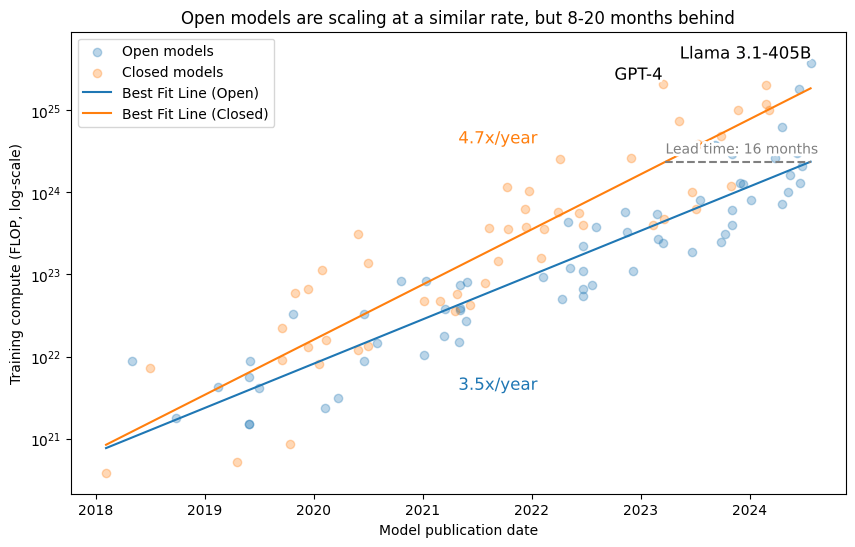

In [47]:
# Graph of the different model fits
# TODO additional plot with big-company models in a different color or marker

model = 'simple'  # ['simple', 'kinked']
colors = {'open': 'C0', 'closed': 'C1'}

# Parameters for the simple model
kink_count = 0
same_intercepts = (False,)
same_slopes = (False,)

# Parameters for the kinked model
# kink_count = 1
# allow_discontinuities = True
# same_intercepts = (True, False)
# same_slopes = (True, True)

def plot_model(df, model_type, kink_count=1, verbose=False):
    if model_type == 'simple':
        fit_result = fit_n_phase_exponential(df, 0, same_intercepts, same_slopes)
    else:
        fit_result = fit_n_phase_exponential(df, kink_count, allow_discontinuities, same_intercepts, same_slopes)

    print(f"Closed slopes: {fit_result.oom_year_slopes['closed']}")
    print(f"Closed intercepts: {fit_result.intercepts['closed']}")
    print(f"Open slopes: {fit_result.oom_year_slopes['open']}")
    print(f"Open intercepts: {fit_result.intercepts['open']}")

    df_open = df[df['category'] == 'Open']
    df_closed = df[df['category'] == 'Closed']

    # Plot the original data points
    plt.figure(figsize=(10, 6))
    plt.scatter(df_open['date'], df_open['log_flop'], label='Open models', alpha=0.3)
    plt.scatter(df_closed['date'], df_closed['log_flop'], label='Closed models', alpha=0.3)

    date_grid = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
    log_flop_open = fit_result.predict(pd.Series(date_grid), pd.Series(['Open'] * len(date_grid))) # we shouldn't need to convert to a Series
    log_flop_closed = fit_result.predict(pd.Series(date_grid), pd.Series(['Closed'] * len(date_grid))) # we shouldn't need to convert to a Series
    plt.plot(date_grid, log_flop_open, color=colors['open'], label='Best Fit Line (Open)')
    plt.plot(date_grid, log_flop_closed, color=colors['closed'], label='Best Fit Line (Closed)')

    # Formatting the plot
    plt.legend()
    if model == 'kinked':
        plt.title(f'Fit of {model_type} model with {kink_count} kinks')
    else:
        # plt.title(f'Fit of {model_type} model')
        plt.title('Open models are scaling at a similar rate, but 8-20 months behind')
    plt.xlabel('Model publication date')
    plt.ylabel('Training compute (FLOP, log-scale)')
    # Set x-axis ticks to show only years
    years = mdates.YearLocator()
    plt.gca().xaxis.set_major_locator(years)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # Set y-axis ticks for scientific notation
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'$10^{{{int(x)}}}$'))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))  # Set major ticks every 5 units

    # # Format the date on the x-axis
    # plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    # plt.gcf().autofmt_xdate()  # Rotation

    # if kink_count == 0 or model == 'simple':
    #     print(f"The slope is: {fit_result.oom_year_slopes[0]:0.2f} OOM/year ({10**fit_result.oom_year_slopes[0]:0.2f}x/year)")
    # else:
    #     oom_year_slopes_str = ', '.join([f'{x:0.2f}' for x in fit_result.oom_year_slopes])
    #     nx_year_slopes_str = ', '.join([f'{10**x:0.2f}' for x in fit_result.oom_year_slopes])
    #     break_points_str = ', '.join([bp.strftime('%Y-%m-%d') for bp in fit_result.break_points_dt])

    #     print(f"The breakpoints are: [{break_points_str}]")
    #     print(f"The slopes are: [{oom_year_slopes_str}] OOM/year ([{nx_year_slopes_str}] x/year)")

    # Add slope labels
    points = [df['date'].min()] + fit_result.break_points_dt + [df['date'].max()]

    for i in range(len(points) - 1):
        for category in ['open', 'closed']:
            mid = points[i] + (points[i+1] - points[i]) / 2
            y = fit_result.predict(pd.Series([mid]), pd.Series([category]))[0]
            plt.text(
               mid,
               y + 1.5 * (1 if category == 'closed' else -1), 
               f'{10**fit_result.oom_year_slopes[category][i]:0.1f}x/year',
               fontsize=12,
               color=colors[category],
               path_effects=[pe.withStroke(linewidth=4, foreground="white")]
            )

    # Plot horizontal line segment showing the lead time
    lead_time_years = calculate_lead_time(df, fit_result)
    end_date = df['date'].max()
    start_date = end_date - pd.DateOffset(days=int(lead_time_years * 365.25))
    y_value = fit_result.predict(pd.Series([end_date]), pd.Series(['Open']))[0]
    plt.hlines(y=y_value, xmin=start_date, xmax=end_date, color='grey', linestyle='--')
    # Label the line
    plt.text(start_date, y_value+0.1, f'Lead time: {lead_time_years*12:.0f} months', fontsize=10, color='grey', path_effects=[pe.withStroke(linewidth=4, foreground="white")])

    # Annotate some key models with text
    key_models = ['GPT-4', 'Llama 3.1-405B']
    for model_name in key_models:
        model_row = df_filtered[df_filtered['System'] == model_name]
        # position top-left
        plt.text(model_row['date'].iloc[0], model_row['log_flop'].iloc[0], model_name, fontsize=12, color='black', path_effects=[pe.withStroke(linewidth=4, foreground="white")], horizontalalignment='right', verticalalignment='bottom')

    if verbose:
      simple_fit = fit_n_phase_exponential(df, 0)
      bayes_factor = np.exp(-0.5 * (fit_result.bic - simple_fit.bic))
      unadjusted_bayes_factor = np.exp(-0.5 * (fit_result.bic - (simple_fit.bic + 2*np.log(len(df_filtered)))))

      print(f"BIC score: {fit_result.bic}")
      bic_score_difference = fit_result.bic - simple_fit.bic
      if bic_score_difference > 0:
        print(f"The simple exponential is preferred over this fit by a BIC score difference of {fit_result.bic - simple_fit.bic}")
      if bic_score_difference < 0:
        print(f"This fit is preferred over a simple exponential by a BIC score difference of {-fit_result.bic - simple_fit.bic}")

    plt.legend()
    # plt.grid(True)

    # Save plot
    fname = f'compute_regression_{model_selection}_frontier={frontier_selection}_top{top_n}_cutoff={cutoff_date}_{model_type}_kinks={kink_count}_same_slope.png'
    plt.savefig(os.path.join(results_dir, fname))

    plt.show()

plot_model(df_filtered, model, kink_count)

## [TODO] Sensitivity analysis to top N choice

In [ ]:
run_bootstrap = True #@param {type:'boolean'}
bootstrap_sample_count = 1000 #@param
max_topN = 20 #@param

if run_bootstrap:
    rows = []
    from tqdm import tqdm

    @dataclass
    class BootstrapResult:
        bic_diffs: tuple[float] = None
        oom_year_simples: tuple[float] = None

        # For the kinked model
        break_points_list: tuple[tuple[pd.Timestamp]] = None
        oom_year_slopes: tuple[tuple[float]] = None

    def bootstrap(model, df, sample_size, kink_count=1, allow_discontinuities=False, verbose=True):
        rng = np.random.default_rng(0)

        bootstrap_result = BootstrapResult()
        bootstrap_result.break_points_list = []
        bootstrap_result.oom_year_slopes = []
        bootstrap_result.oom_year_simples = []
        bootstrap_result.bic_diffs = []

        if verbose:
            print('Bootstrapping')
        for bootstrap_index in range(sample_size):
            if verbose:
                if bootstrap_index % 10 == 0:
                    print(f'  Computing bootstrap {bootstrap_index}/{sample_size}')

            sample = df.sample(len(df), replace=True, random_state=rng)
            sample = sample.sort_values('date')

            simple_fit = fit_n_phase_exponential(sample, 0)

            if model == 'hyperbolic':
                fit_result = fit_hyperbolic(sample)
            else:
                fit_result = fit_n_phase_exponential(sample, kink_count, allow_discontinuities)

            # BIC difference over simple exponential
            bic_diff = fit_result.bic - simple_fit.bic
            bootstrap_result.bic_diffs.append(bic_diff)

            bootstrap_result.oom_year_slopes.append(fit_result.oom_year_slopes)
            bootstrap_result.break_points_list.append(fit_result.break_points_dt)
            bootstrap_result.oom_year_simples.append(simple_fit.oom_year_slopes[0])

        bootstrap_result.oom_year_slopes = np.array(bootstrap_result.oom_year_slopes)
        bootstrap_result.break_points_list = np.array(bootstrap_result.break_points_list)
        bootstrap_result.oom_year_simples = np.array(bootstrap_result.oom_year_simples)

        return bootstrap_result


    for top_n in tqdm(range(5, max_topN + 1)):
        df_top = find_top_models_up_to_release(df_notable, top_n)  # NOTE: df_notable is a copy of the initial df_filtered
        df_top = df_top[df_top['date'] > cutoff_date]

        bootstrap_result = bootstrap('kinked', df_top, bootstrap_sample_count, verbose=False)

        ci_width = 0.90
        qs = [(1 - ci_width)/2, 0.5, (1 + ci_width)/2]
        bic_diff_quantiles = np.quantile(bootstrap_result.bic_diffs, qs)
        pos_bic_diff_percent = (np.array(bootstrap_result.bic_diffs) > 0).mean()
        simple_nx_year_quantiles = 10**np.quantile(bootstrap_result.oom_year_simples, qs)

        row = []
        row.append(top_n)
        row.append(f'{bic_diff_quantiles[1]:.2f} (90% CI: {bic_diff_quantiles[0]:.2f} to {bic_diff_quantiles[2]:.2f})')
        row.append(f'{1 - pos_bic_diff_percent:.0%}')
        row.append(f'{simple_nx_year_quantiles[1]:.2f} (90% CI: {simple_nx_year_quantiles[0]:.2f} to {simple_nx_year_quantiles[2]:.2f})')
        rows.append(row)

    df_results = pd.DataFrame(rows, columns=['top_n', 'BIC difference', '% times discontinuity preferred', 'Simple fit slope (x/year)'])

In [ ]:
df_results